# Yesil Society - Atölye Çalışması 

Bu dosyada baştan sona  yapay sinir ağının sadece numpy kullanarak kodlanması yer almaktadır.  Bu atölye çalışması, Yesil Society etkinliği kapsamında düzenlenmektedir. Bu atölye çalışmasında  Coursera'daki "Deep Learning Specialization" kursundan yararlanmıştır. Veriseti ve "lr_utils" Coursera'ya aittir.

### Drive ayarlarının yapılması 

Dosya yolunu drive'da gösterebilmek için bulunduğumuz drive klasörünü aktifleştirmemiz gerekir ve belirlediğimiz drive dosyasına atacağımız dosyaları kolay bir şekilde okuyabiliriz.

In [1]:
'''from google.colab import drive
drive.mount('/content/gdrive')
cd /content/gdrive/My\ Drive/ysworkshop
'''

"from google.colab import drive\ndrive.mount('/content/gdrive')\ncd /content/gdrive/My\\ Drive/ysworkshop\n"

# Kütüphaneler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

Veriyi yükleme:
Problem : Verilmiş ("data.h5") verisetinde:
- m_train etiketlenmiş kedi (y=1) ya da kedi değil (y = 0) eğitim verileri
- test verileri
-sınıf bilgileri
-her görselin shape'i (num_px, num_px, 3) olarak geçer, 3 renk türünü temsil eder (RGB)

bu problemde görüntü sınıflandırma algoritması geliştireceğiz.


In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1]cat


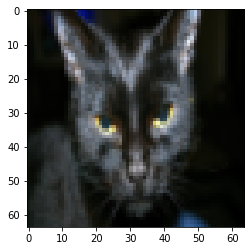

In [4]:
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") )

In [5]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Eğitim örnekleri: m_train = " + str(m_train))
print ("Test örnekleri: : m_test = " + str(m_test))
print ("Yükseklik/Genişlik - Her bir görsel için: Height/Width of each image: num_px = " + str(num_px))


Eğitim örnekleri: m_train = 209
Test örnekleri: : m_test = 50
Yükseklik/Genişlik - Her bir görsel için: Height/Width of each image: num_px = 64


Bundan sonra şekil görüntülerini eğitirken matris/vektör hatası karşılaşmamız için görüntüyü tekrardan reshape yapmamız gerekiyor.

(num_px  ∗∗  num_px  ∗∗  3, 1)

In [6]:
print ("Düzleştirilmemiş Train X: " + str(train_set_x_orig.shape))
print ("Düzleştirilmemiş Train Y: " + str(test_set_x_orig.shape))

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("Düzleştirilmiş Train X: " + str(train_set_x_flatten.shape))
print ("Düzleştirilmiş Train Y: " + str(train_set_y.shape))

Düzleştirilmemiş Train X: (209, 64, 64, 3)
Düzleştirilmemiş Train Y: (50, 64, 64, 3)
Düzleştirilmiş Train X: (12288, 209)
Düzleştirilmiş Train Y: (1, 209)


Renkli görüntüleri temsil etmek için, her piksel için kırmızı, yeşil ve mavi kanalların (RGB) belirtilmesi gerekir ve bu nedenle piksel değeri aslında 0 - 255 arasında değişen üç sayının bir vektörüdür. 

Makine öğreniminde ortak bir ön işleme adımı merkezlemektir. ve veri kümenizi standartlaştırın, yani tüm numpy dizisinin ortalamasını her örnekten çıkartırsınız ve sonra her örneği tüm numpy dizisinin standart sapmasına bölersiniz. Ancak, resim veri kümeleri için daha basit ve daha elverişlidir ve veri kümesinin her satırını 255'e (bir piksel kanalının maksimum değeri) bölmek için neredeyse aynı şekilde çalışır.

In [7]:
print(train_set_x_flatten)
print("-------------------------------")
train_set_x = train_set_x_flatten/255.
print(train_set_x)
test_set_x = test_set_x_flatten/255.

[[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]
-------------------------------
[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


**Algoritmanın matematiksel olarak gösterimi**:

Bir örnek için: $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Maliyet sonra tüm eğitim örnekleri üzerinde toplanmasıyla hesaplanır:

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

<img src="LogReg_kiank.png" style="width:650px;height:400px;">

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [8]:
def sigmoid(z):
   
    s = 1 / (1 + np.exp(-z))
    
    return s

In [9]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


W'yi sıfır vektörü olarak başlatmalısınız.

In [10]:
def initialize_with_zeros(dim):
 
    w = np.zeros(shape=(dim, 1))
    b = 0

    return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.3 - Forward and Backward propagation
Forward Propagation:
- X girdi
- Hesaplama $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Lazım olacak 2 formül:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
def propagate(w, b, X, Y):
    """
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as 
   
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)  # 
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) 
  
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [13]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - Optimization

In [14]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
      
        grads, cost = propagate(w, b, X, Y)
     
        
      
        dw = grads["dw"]
        db = grads["db"]
        
        
        w = w - learning_rate * dw  
        b = b - learning_rate * db
    
        
       
        if i % 100 == 0:
            costs.append(cost)
        
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


In [16]:


def predict(w, b, X):
    '''  
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
   
    A = sigmoid(np.dot(w.T, X) + b) 
 
    
    for i in range(A.shape[1]):
        
     
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [17]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## 5 - Fonksiyonları birleştirelim ##


In [18]:


def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
  
    
  
    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
  
    w = parameters["w"]
    b = parameters["b"]
      
    Y_prediction_test = predict(w,b, X_test)
    Y_prediction_train = predict(w, b, X_train)

 

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [19]:
print(train_set_x)

[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


In [20]:
print(train_set_y)

[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]


In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


1.0

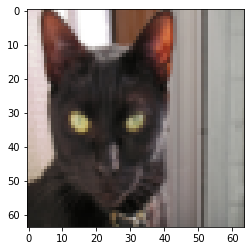

In [54]:
# 1 = Kedi, 0 = Kedi Değil
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
d["Y_prediction_test"][0,index]

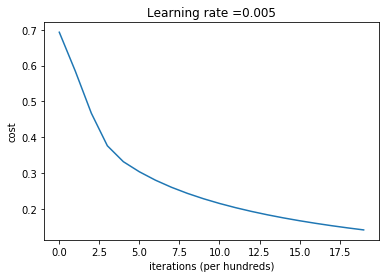

In [31]:

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()